# War fatalities in Russia in 2022--2023 estimated via excess male mortality
## Figure 1 and variants

In [1]:
%matplotlib inline

import numpy as np
import pylab as plt
import pandas as pd

from sklearn.linear_model import LinearRegression

plt.style.use("mpl_style.txt")

In [2]:
df = pd.read_csv('../deaths-by-age-gender-region-year/deaths-by-age-gender-region-year-1990-2023.csv.gz')

df

,Region,Year,Age,Gender,Deaths
0,Алтайский край,1990,0-4 лет,f,264
1,Алтайский край,1990,10-14 лет,f,28
2,Алтайский край,1990,15-19 лет,f,63
3,Алтайский край,1990,20-24 лет,f,67
4,Алтайский край,1990,25-29 лет,f,94
...,...,...,...,...,...
116691,Ярославская область,2023,75-79 лет,m,681
116692,Ярославская область,2023,80-84 лет,m,727
116693,Ярославская область,2023,85 и более,m,733
116694,Ярославская область,2023,Неизвестно,m,5


In [3]:
# Load HIV deaths

df_hiv = pd.read_excel('../deaths-hiv/deaths-hiv.xlsx', skiprows=1, index_col=0)

hiv_m = df_hiv.values[1:, 1::3].astype(int)
hiv_f = df_hiv.values[1:, 2::3].astype(int)

# Getting values for 0 year old by subtracting the sum over 1+ (and unknown) from the total
hiv_m[0] -= hiv_m[1:].sum(axis=0)
hiv_f[0] -= hiv_f[1:].sum(axis=0)

# Load 2023 data
df_hiv_2023 = pd.read_excel('../deaths-hiv/deaths-hiv-2023.xlsx', skiprows=1)

hiv_m_2023 = df_hiv_2023[98:].values[0, 2:] # includes 0 year old
hiv_m_2023[hiv_m_2023 == '-'] = 0
hiv_m_2023 = hiv_m_2023.astype(int)

hiv_f_2023 = df_hiv_2023[195:].values[0, 2:]
hiv_f_2023[hiv_f_2023 == '-'] = 0
hiv_f_2023 = hiv_f_2023.astype(int)

# Combine
hiv_m = np.concatenate((hiv_m, hiv_m_2023[:, np.newaxis]), axis=1)
hiv_f = np.concatenate((hiv_f, hiv_f_2023[:, np.newaxis]), axis=1)

# Summing over 5-year bands
hiv_m = hiv_m[:-2].reshape(-1, 5, hiv_m.shape[-1]).sum(axis=1)
hiv_f = hiv_f[:-2].reshape(-1, 5, hiv_f.shape[-1]).sum(axis=1)

hiv_years = np.arange(2006, 2024)

Excess 2022 over 7 groups: 23,594
Excess 2023 over 7 groups: 40,542
Excess 2022/23 over 7 groups: 64,136


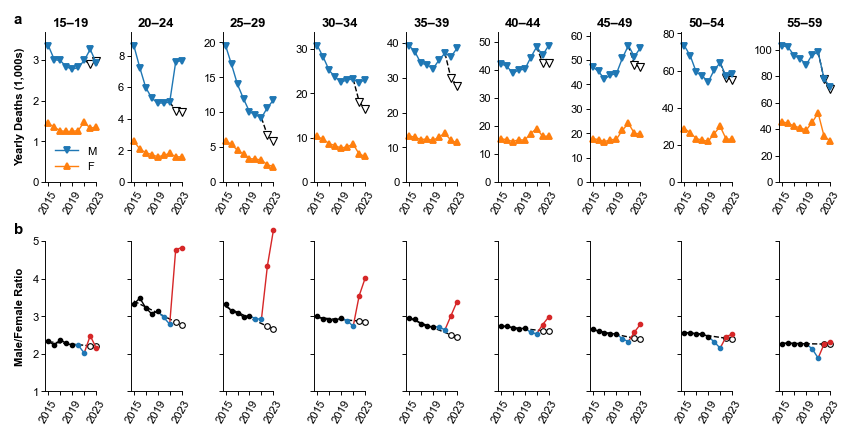

In [4]:
# Main figure

region = 'Российская Федерация'

fig, axs = plt.subplots(nrows=2, ncols=9, figsize=(6.2, 3.1))

agegroups = ['15-19 лет', '20-24 лет', '25-29 лет',
       '30-34 лет', '35-39 лет', '40-44 лет', '45-49 лет', 
       '50-54 лет', '55-59 лет']

agegroups_shortened = [a[:2] + '–' + a[3:5] for a in agegroups]

LinReg = LinearRegression()

excess22 = 0
excess23 = 0

for i, age in enumerate(agegroups):
    # Get data
    male = df[
        (df.Region == region) & 
        (df.Age == age) & 
        (df.Gender == 'm') & 
        (df.Year >= 2015)
    ][['Year', 'Deaths']].values
    
    female = df[
        (df.Region == region) & 
        (df.Age == age) & 
        (df.Gender == 'f') & 
        (df.Year >= 2015)
    ][['Year', 'Deaths']].values
        
    # Do computations
    x = np.arange(2015, 2024)
    ratio = male[:,1] / female[:,1]
        
    LinReg.fit(x[-9:-4].reshape(-1,1), ratio[-9:-4].reshape(-1,1))
    yhat = LinReg.predict(x[-9:].reshape(-1,1))
    
    baseline22 = yhat[-2,0] * female[-2,1] / 1000
    baseline23 = yhat[-1,0] * female[-1,1] / 1000
        
    if i <= 6:
        excess22 += male[-2,1] - baseline22 * 1000
        excess23 += male[-1,1] - baseline23 * 1000
    
    # Plot
    ax1 = axs.flatten()[i]
    ax2 = axs.flatten()[i + len(agegroups)]

    ax1.plot(x, male[:,1] / 1000, 'v-', label='М', clip_on=False, markersize=3)
    ax1.plot(x, female[:,1] / 1000, '^-', label='F', clip_on=False, markersize=3)
    
    ax1.plot(x[-3:], [male[-3,1]/1000, baseline22, baseline23], '--', color='k', zorder=-2)
    ax1.plot(x[-2], baseline22, 'v', color='w', markeredgecolor='k', 
            markersize=4, markeredgewidth=.6, zorder=-2, clip_on=False)
    ax1.plot(x[-1], baseline23, 'v', color='w', markeredgecolor='k', 
            markersize=4, markeredgewidth=.6, zorder=-2, clip_on=False)

    ax1.set_title(agegroups_shortened[i], fontweight="bold")
    ax1.set_xticks([2015, 2017, 2019, 2021, 2023])
    ax1.set_xlim([2014.5, 2023])
    ax1.set_xticklabels([2015, '', 2019, '', 2023], rotation=60)
    ax1.set_ylim([0, np.max(male[:,1] / 1000) * 1.1])
    
    if i == 6:
        ax1.set_yticks([0, 10, 20, 30, 40, 50, 60])
            
    if i == 0:
        ax1.legend()
        ax1.set_ylabel(r'Yearly Deaths (1,000s)', fontweight="bold")
        ax1.set_yticks([0, 1, 2, 3])

        ax2.set_ylabel(r'Male/Female Ratio', fontweight="bold")
    else:
        ax2.set_yticklabels([])
    
    ax2.plot(x[:-4], ratio[:-4], 'k.-')
    ax2.plot(x[-5:-2], ratio[-5:-2], '-', color='tab:blue', zorder=-1)
    ax2.plot(x[-4:-2], ratio[-4:-2], '.', color='tab:blue')
    ax2.plot(x[-3:], ratio[-3:], '-', color='tab:red', zorder=-1, clip_on=False)
    ax2.plot(x[-2], ratio[-2], '.', color='tab:red', clip_on=False)
    ax2.plot(x[-1], ratio[-1], '.', color='tab:red', clip_on=False)
        
    ax2.plot(x[-9:], yhat, '--', color='k', zorder=-2)
    ax2.plot(x[-2], yhat[-2], 'o', color='w', markeredgecolor='k', 
            markersize = 3, markeredgewidth=.6, zorder=-2, clip_on=False)
    ax2.plot(x[-1], yhat[-1], 'o', color='w', markeredgecolor='k', 
            markersize = 3, markeredgewidth=.6, zorder=-2, clip_on=False)
                            
    ax2.set_ylim([1,5])        
    ax2.set_xticks([2015, 2017, 2019, 2021, 2023])
    ax2.set_xlim([2014.5, 2023])
    ax2.set_xticklabels([2015, '', 2019, '', 2023], rotation=60)
    ax2.set_yticks([1,2,3,4,5]) 

fig.align_ylabels()

fig.text(.005, .97, 'a', fontsize=8, weight='bold')
fig.text(.005, .47, 'b', fontsize=8, weight='bold')

fig.savefig('figures/mainfig.png')
fig.savefig('figures/mainfig.pdf')

print(f'Excess 2022 over 7 groups: {excess22:,.0f}')
print(f'Excess 2023 over 7 groups: {excess23:,.0f}')
print(f'Excess 2022/23 over 7 groups: {excess22 + excess23:,.0f}')

Excess 2022 over 7 groups: 20,618
Excess 2023 over 7 groups: 37,864
Excess 2022/23 over 7 groups: 58,482


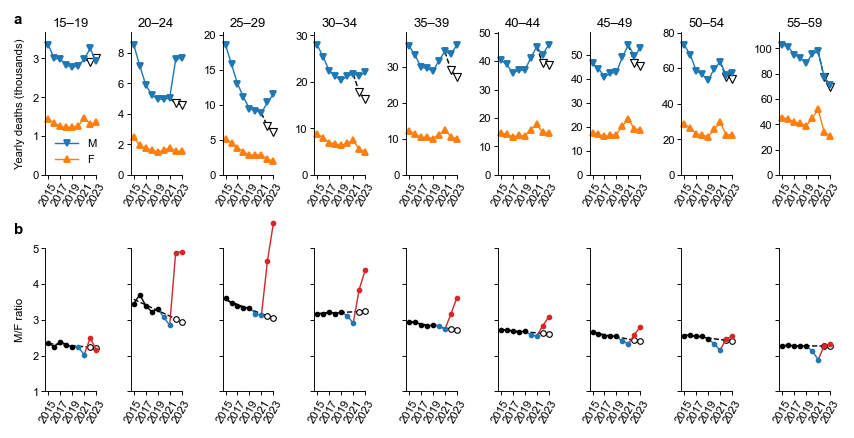

In [5]:
# Same but with HIV subtracted

region = 'Российская Федерация'

fig, axs = plt.subplots(nrows=2, ncols=9, figsize=(6.2, 3.1))

agegroups = ['15-19 лет', '20-24 лет', '25-29 лет',
       '30-34 лет', '35-39 лет', '40-44 лет', '45-49 лет', 
       '50-54 лет', '55-59 лет']

agegroups_shortened = [a[:2] + '–' + a[3:5] for a in agegroups]

LinReg = LinearRegression()

excess22 = 0
excess23 = 0

for i, age in enumerate(agegroups):
    # Get data
    male = df[
        (df.Region == region) & 
        (df.Age == age) & 
        (df.Gender == 'm') & 
        (df.Year >= 2015)
    ][['Year', 'Deaths']].values
    
    female = df[
        (df.Region == region) & 
        (df.Age == age) & 
        (df.Gender == 'f') & 
        (df.Year >= 2015)
    ][['Year', 'Deaths']].values
    
    male[:,1] -= hiv_m[3 + i, hiv_years >= 2015]
    female[:,1] -= hiv_f[3 + i, hiv_years >= 2015]

    # Do computations
    x = np.arange(2015, 2024)
    ratio = male[:,1] / female[:,1]
        
    LinReg.fit(x[-9:-4].reshape(-1,1), ratio[-9:-4].reshape(-1,1))
    yhat = LinReg.predict(x[-9:].reshape(-1,1))
    
    baseline22 = yhat[-2,0] * female[-2,1] / 1000
    baseline23 = yhat[-1,0] * female[-1,1] / 1000
        
    if i <= 6:
        excess22 += male[-2,1] - baseline22 * 1000
        excess23 += male[-1,1] - baseline23 * 1000
        
    # Plot
    ax1 = axs.flatten()[i]
    ax2 = axs.flatten()[i + len(agegroups)]

    ax1.plot(x, male[:,1] / 1000, 'v-', label='М', clip_on=False, markersize=3)
    ax1.plot(x, female[:,1] / 1000, '^-', label='F', clip_on=False, markersize=3)
    
    ax1.plot(x[-3:], [male[-3,1]/1000, baseline22, baseline23], '--', color='k', zorder=-2)
    ax1.plot(x[-2], baseline22, 'v', color='w', markeredgecolor='k', 
            markersize=4, markeredgewidth=.6, zorder=-2, clip_on=False)
    ax1.plot(x[-1], baseline23, 'v', color='w', markeredgecolor='k', 
            markersize=4, markeredgewidth=.6, zorder=-2, clip_on=False)

    ax1.set_title(agegroups_shortened[i])
    ax1.set_xticks([2015, 2017, 2019, 2021, 2023])
    ax1.set_xlim([2014.5, 2023])
    ax1.set_xticklabels([2015, 2017, 2019, 2021, 2023], rotation=60)
    ax1.set_ylim([0, np.max(male[:,1] / 1000) * 1.1])
            
    if i == 0:
        ax1.legend()
        ax1.set_ylabel(r'Yearly deaths (thousands)')
        ax1.set_yticks([0, 1, 2, 3])

        ax2.set_ylabel(r'M/F ratio')
    else:
        ax2.set_yticklabels([])
    
    ax2.plot(x[:-4], ratio[:-4], 'k.-')
    ax2.plot(x[-5:-2], ratio[-5:-2], '-', color='tab:blue', zorder=-1)
    ax2.plot(x[-4:-2], ratio[-4:-2], '.', color='tab:blue')
    ax2.plot(x[-3:], ratio[-3:], '-', color='tab:red', zorder=-1, clip_on=False)
    ax2.plot(x[-2], ratio[-2], '.', color='tab:red', clip_on=False)
    ax2.plot(x[-1], ratio[-1], '.', color='tab:red', clip_on=False)
        
    ax2.plot(x[-9:], yhat, '--', color='k', zorder=-2)
    ax2.plot(x[-2], yhat[-2], 'o', color='w', markeredgecolor='k', 
            markersize = 3, markeredgewidth=.6, zorder=-2, clip_on=False)
    ax2.plot(x[-1], yhat[-1], 'o', color='w', markeredgecolor='k', 
            markersize = 3, markeredgewidth=.6, zorder=-2, clip_on=False)
                            
    ax2.set_ylim([1,5])        
    ax2.set_xticks([2015, 2017, 2019, 2021, 2023])
    ax2.set_xlim([2014.5, 2023])
    ax2.set_xticklabels([2015, 2017, 2019, 2021, 2023], rotation=60)
    ax2.set_yticks([1,2,3,4,5]) 

fig.align_ylabels()

fig.text(.005, .97, 'a', fontsize=8, weight='bold')
fig.text(.005, .47, 'b', fontsize=8, weight='bold')

fig.savefig('figures/mainfig-nohiv.png')
fig.savefig('figures/mainfig-nohiv.pdf')

print(f'Excess 2022 over 7 groups: {excess22:,.0f}')
print(f'Excess 2023 over 7 groups: {excess23:,.0f}')
print(f'Excess 2022/23 over 7 groups: {excess22 + excess23:,.0f}')

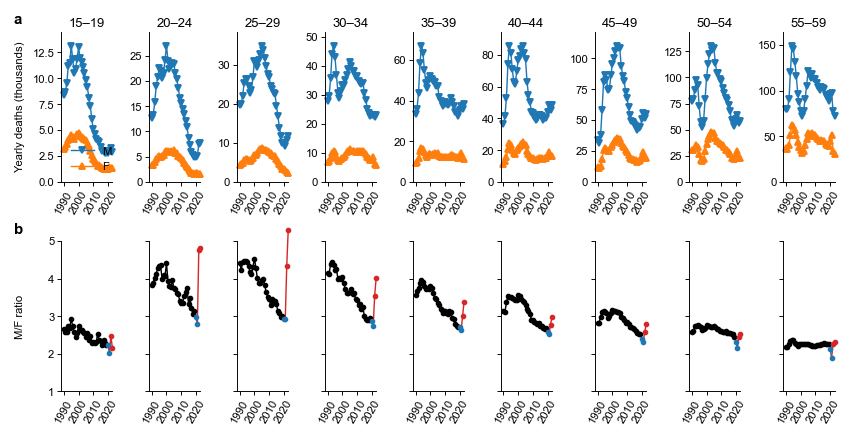

In [3]:
# Longer time period

region = 'Российская Федерация'

fig, axs = plt.subplots(nrows=2, ncols=9, figsize=(6.2, 3.1))

agegroups = ['15-19 лет', '20-24 лет', '25-29 лет',
       '30-34 лет', '35-39 лет', '40-44 лет', '45-49 лет', 
       '50-54 лет', '55-59 лет']

agegroups_shortened = [a[:2] + '–' + a[3:5] for a in agegroups]

LinReg = LinearRegression()

for i, age in enumerate(agegroups):
    # Get data
    male = df[
        (df.Region == region) & 
        (df.Age == age) & 
        (df.Gender == 'm') & 
        (df.Year >= 1990)
    ][['Year', 'Deaths']].values
    
    female = df[
        (df.Region == region) & 
        (df.Age == age) & 
        (df.Gender == 'f') & 
        (df.Year >= 1990)
    ][['Year', 'Deaths']].values
    
    # Do computations
    x = np.arange(1990, 2024)
    ratio = male[:,1] / female[:,1]
    
    # Plot
    ax1 = axs.flatten()[i]
    ax2 = axs.flatten()[i + len(agegroups)]

    ax1.plot(x, male[:,1] / 1000, 'v-', label='М', clip_on=False, markersize=3)
    ax1.plot(x, female[:,1] / 1000, '^-', label='F', clip_on=False, markersize=3)
    
    ax1.set_title(agegroups_shortened[i])
    ax1.set_xticks([1990, 2000, 2010, 2020])
    ax1.set_xlim([1988, 2023])
    ax1.set_xticklabels([1990, 2000, 2010, 2020], rotation=60)
    ax1.set_ylim([0, np.max(male[:,1] / 1000) * 1.1])
            
    if i == 0:
        ax1.legend(loc='lower left')
        ax1.set_ylabel(r'Yearly deaths (thousands)')

        ax2.set_ylabel(r'M/F ratio')
    else:
        ax2.set_yticklabels([])
    
    ax2.plot(x[:-4], ratio[:-4], 'k.-')
    ax2.plot(x[-5:-2], ratio[-5:-2], '-', color='tab:blue', zorder=-1, clip_on=False)
    ax2.plot(x[-4:-2], ratio[-4:-2], '.', color='tab:blue', clip_on=False)
    ax2.plot(x[-3:], ratio[-3:], '-', color='tab:red', zorder=-1, clip_on=False)
    ax2.plot(x[-2], ratio[-2], '.', color='tab:red', clip_on=False)
    ax2.plot(x[-1], ratio[-1], '.', color='tab:red', clip_on=False)
                                    
    ax2.set_ylim([1, 5])        
    ax2.set_xticks([1990, 2000, 2010, 2020])
    ax2.set_xlim([1988, 2023])
    ax2.set_xticklabels([1990, 2000, 2010, 2020], rotation=60)
    ax2.set_yticks([1,2,3,4,5]) 
    
fig.align_ylabels()

fig.text(.005, .97, 'a', fontsize=8, weight='bold')
fig.text(.005, .47, 'b', fontsize=8, weight='bold')

fig.savefig('figures/suppfig-part1.png')
fig.savefig('figures/suppfig-part1.pdf')

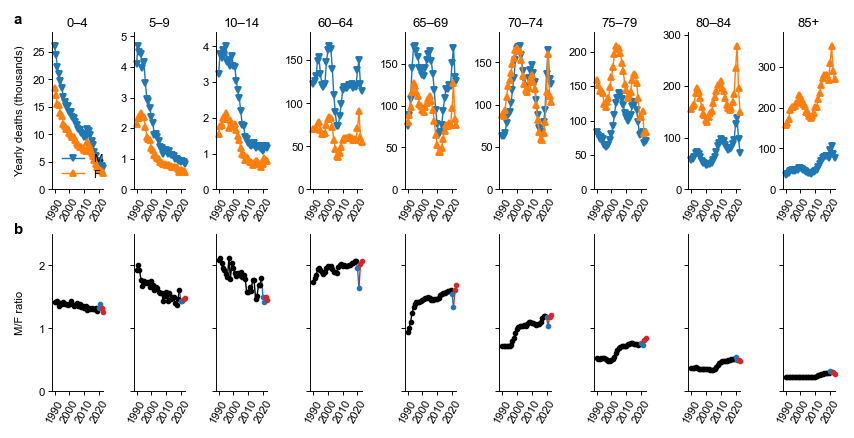

In [4]:
# Longer time period, all other age groups

region = 'Российская Федерация'

fig, axs = plt.subplots(nrows=2, ncols=9, figsize=(6.2, 3.1))

agegroups = ['0-4 лет', '5-9 лет', '10-14 лет',
       '60-64 лет', '65-69 лет', '70-74 лет', '75-79 лет', 
       '80-84 лет', '85 и более']

agegroups_shortened = [a[:2] + '–' + a[3:5] for a in agegroups]
agegroups_shortened[0] = '0–4'
agegroups_shortened[1] = '5–9'
agegroups_shortened[-1] = '85+'

LinReg = LinearRegression()

for i, age in enumerate(agegroups):
    # Get data
    male = df[
        (df.Region == region) & 
        (df.Age == age) & 
        (df.Gender == 'm') & 
        (df.Year >= 1990)
    ][['Year', 'Deaths']].values
    
    female = df[
        (df.Region == region) & 
        (df.Age == age) & 
        (df.Gender == 'f') & 
        (df.Year >= 1990)
    ][['Year', 'Deaths']].values
    
    # Do computations
    x = np.arange(1990, 2024)
    ratio = male[:,1] / female[:,1]
    
    # Plot
    ax1 = axs.flatten()[i]
    ax2 = axs.flatten()[i + len(agegroups)]

    ax1.plot(x, male[:,1] / 1000, 'v-', label='М', clip_on=False, markersize=3)
    ax1.plot(x, female[:,1] / 1000, '^-', label='F', clip_on=False, markersize=3)
    
    ax1.set_title(agegroups_shortened[i])
    ax1.set_xticks([1990, 2000, 2010, 2020])
    ax1.set_xlim([1988, 2023])
    ax1.set_xticklabels([1990, 2000, 2010, 2020], rotation=60)
    ax1.set_ylim([0, np.max(np.maximum(male, female)[:,1] / 1000) * 1.1])
            
    if i == 0:
        ax1.legend(loc='lower left')
        ax1.set_ylabel(r'Yearly deaths (thousands)')

        ax2.set_ylabel(r'M/F ratio')
    else:
        ax2.set_yticklabels([])
    
    ax2.plot(x[:-4], ratio[:-4], 'k.-')
    ax2.plot(x[-5:-2], ratio[-5:-2], '-', color='tab:blue', zorder=-1, clip_on=False)
    ax2.plot(x[-4:-2], ratio[-4:-2], '.', color='tab:blue', clip_on=False)
    ax2.plot(x[-3:], ratio[-3:], '-', color='tab:red', zorder=-1)
    ax2.plot(x[-2], ratio[-2], '.', color='tab:red', clip_on=False)
    ax2.plot(x[-1], ratio[-1], '.', color='tab:red', clip_on=False)
                                    
    ax2.set_ylim([0, 2.5])        
    ax2.set_xticks([1990, 2000, 2010, 2020])
    ax2.set_xlim([1988, 2023])
    ax2.set_xticklabels([1990, 2000, 2010, 2020], rotation=60)
    ax2.set_yticks([0, 1, 2]) 
    
fig.align_ylabels()

fig.text(.005, .97, 'a', fontsize=8, weight='bold')
fig.text(.005, .47, 'b', fontsize=8, weight='bold')

fig.savefig('figures/suppfig-part2.png')
fig.savefig('figures/suppfig-part2.pdf')